In [22]:
import numpy as np

from betaburst.detection.burst_analysis import TfBursts

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import set_random_seed, create_times

import matplotlib.pyplot as plt



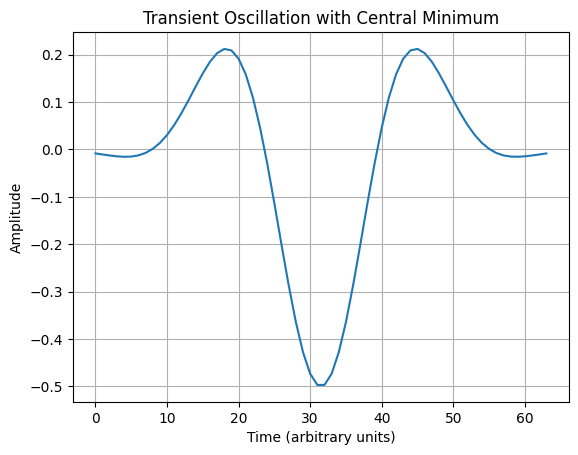

In [23]:
def generate_transient_minimum(w_size, freq=1, amplitude=0.5, decay=0.002):
    """
    Generate a transient oscillation with a clear local minimum at the center.
    
    Parameters:
        w_size (int): The size of the window (number of data points).
        freq (float): The frequency of the oscillation (controls how many oscillations occur).
        amplitude (float): The amplitude of the oscillation.
        decay (float): Decay factor for the transient effect.
        
    Returns:
        np.ndarray: Array containing the transient oscillation with a minimum at the center.
    """
    # Time vector centered around zero
    t = np.linspace(-1, 1, w_size)
    
    # Oscillatory part (inverted cosine wave) ensuring a minimum at the center
    oscillation = -amplitude * np.cos(2 * np.pi * freq * t)
    
    # Apply a Gaussian window to create the transient effect
    window = np.exp(-decay * (t * w_size) ** 2)
    
    # Combine the oscillation and the window
    transient_oscillation = oscillation * window
    
    return transient_oscillation

# Example usage
w_size = 64
signal = generate_transient_minimum(w_size, decay=0.001)

# Plot the result
plt.plot(signal)
plt.title("Transient Oscillation with Central Minimum")
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [24]:
set_random_seed(42) # Reproducibility

# Simulation settings
fs = 250
n_epochs = 10
n_seconds = n_epochs*2*5
exponent = -1
sig = sim_powerlaw(n_seconds, fs, exponent, f_range=(1, None))
times = create_times(n_seconds, fs)
epochs = sig.reshape((n_epochs, 2, 5*fs)) /10 # MNE format: (epoch, channel, trial)

# epochs = np.random.randn(n_epochs, 2, 5*fs) / 10

print(np.max(epochs))
print(np.min(epochs))
f_stim = 15
length = 0.16
w_size = int(length*fs)
t = np.arange(0, length, 1/fs)

epochs[0, 0, int(1*fs):int((1+length)*fs)] +=  7*generate_transient_minimum(w_size, decay=0.002)
epochs[2, 0, int(2*fs):int((2+length)*fs)] +=  7*generate_transient_minimum(w_size, decay=0.0005)
epochs[4, 0, int(3.5*fs):int((3.5+length)*fs)] +=  7*generate_transient_minimum(w_size,  decay=0.001)
epochs[8, 0, int(1*fs):int((1+length)*fs)] +=  7*generate_transient_minimum(w_size, decay=0.00001)
epochs[8, 0, int(2*fs):int((2+length)*fs)] +=  7*generate_transient_minimum(w_size,  decay=0.002)

# epochs[1, 0, int(1*fs):int((1+length)*fs)] +=  5*np.sin(2*np.pi*t*f_stim)
# epochs[3, 0, int(2*fs):int((2+length)*fs)] +=  5*np.sin(2*np.pi*t*(f_stim+4))
# epochs[5, 0, int(3.5*fs):int((3.5+length)*fs)] +=  5*np.sin(2*np.pi*t*(f_stim+4))
# epochs[9, 0, int(1*fs):int((1+length)*fs)] +=  5*np.sin(2*np.pi*t*(f_stim+7))
# epochs[9, 0, int(3*fs):int((3+length)*fs)] += 5*np.sin(2*np.pi*t*f_stim)



1.4622729365273412
-1.2544040971168229


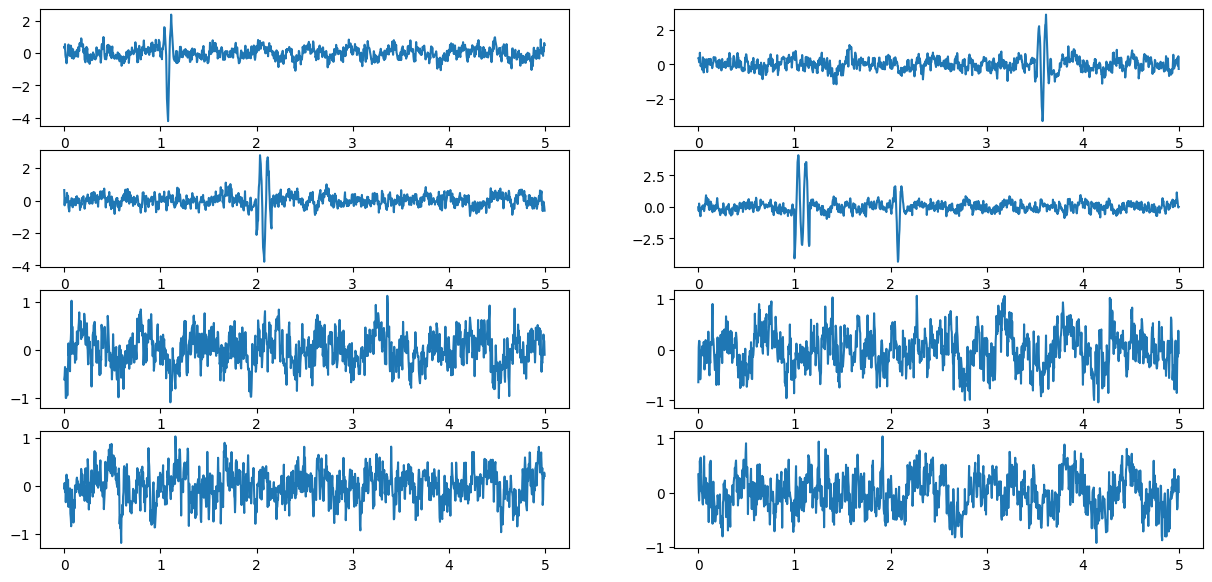

In [25]:
plt.figure(figsize=(15,7))
plt.subplot(4,2,1)
plt.plot(np.arange(0, 5, 1/fs), epochs[0,0,:])
plt.subplot(4,2,2)
plt.plot(np.arange(0, 5, 1/fs), epochs[4,0,:])
plt.subplot(4,2,3)
plt.plot(np.arange(0, 5, 1/fs), epochs[2,0,:])
plt.subplot(4,2,4)
plt.plot(np.arange(0, 5, 1/fs), epochs[8,0,:])


plt.subplot(4,2,5)
plt.plot(np.arange(0, 5, 1/fs), epochs[1,0,:])
plt.subplot(4,2,6)
plt.plot(np.arange(0, 5, 1/fs), epochs[5,0,:])
plt.subplot(4,2,7)
plt.plot(np.arange(0, 5, 1/fs), epochs[3,0,:])
plt.subplot(4,2,8)
plt.plot(np.arange(0, 5, 1/fs), epochs[9,0,:])

In [26]:
freq_step = 0.5
freqs = np.arange(5.0, 47.0, freq_step)
upto_gamma_band = np.array([8, 40])
upto_gamma_range = np.where(
    np.logical_and(freqs >= upto_gamma_band[0], freqs <= upto_gamma_band[1])
)[0]

bm =  TfBursts(
        fs,
        freqs = freqs,
        fr_band = upto_gamma_band,
        band_search_range = upto_gamma_range,
        band_limits=[8, 10, 35],
        remove_fooof=False,
    )

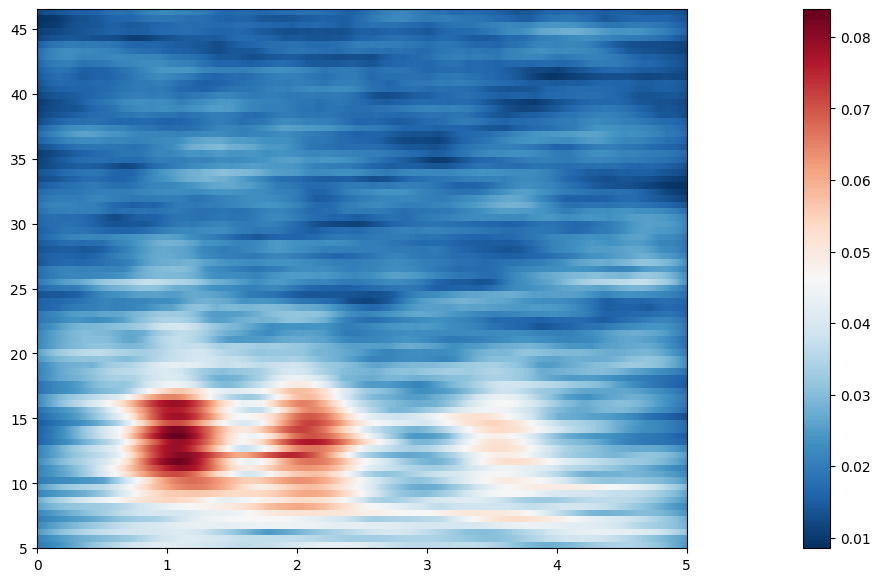

In [27]:
tfs = bm._apply_tf(epochs)
av_psds = np.mean(
             tfs, axis=0
        )
plt.figure(figsize=(30,7))
plt.imshow(av_psds[0,:,:],  aspect=1/10, cmap="RdBu_r", interpolation="none", origin="lower", extent=[0, epochs.shape[2]/fs,  freqs[0], freqs[-1]])
plt.colorbar()

In [28]:
bursts = bm.burst_extraction(epochs, band="beta")

Initiating beta band burst extraction without aperiodic activity subtraction...
	Burst extraction for all channels: from 10 to 35 Hz.


In [ ]:
print(np.sort(bursts[0]['peak_time']))
print(np.sort(bursts[1]['peak_time']))


[0.48  1.081 1.621 2.118 2.89  3.583 4.323 4.676]
[0.536 1.017 1.757 2.93  3.543 4.059 4.732]


7


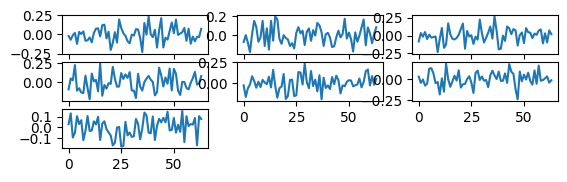

In [ ]:
nb_bursts = len(bursts[1]['waveform'])
print(nb_bursts)
for idx, burst in enumerate(bursts[1]['waveform']):
    plt.subplot(8,3,idx+1)
    plt.plot(burst)

8


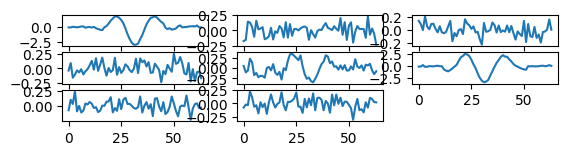

In [ ]:
nb_bursts = len(bursts[0]['waveform'])
print(nb_bursts)
for idx, burst in enumerate(bursts[0]['waveform']):
    plt.subplot(10,3,idx+1)
    plt.plot(burst)

Trial idx: 8


C:\Users\ludov\AppData\Local\Temp\ipykernel_4184\3977840654.py:149: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


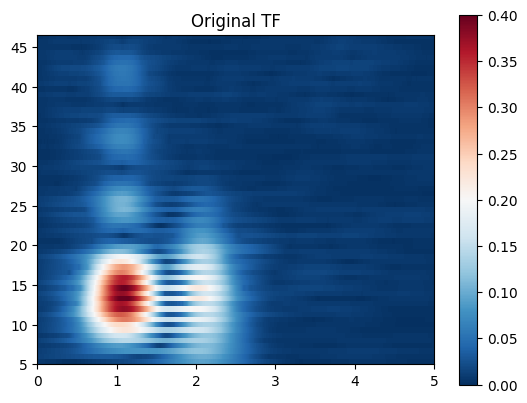

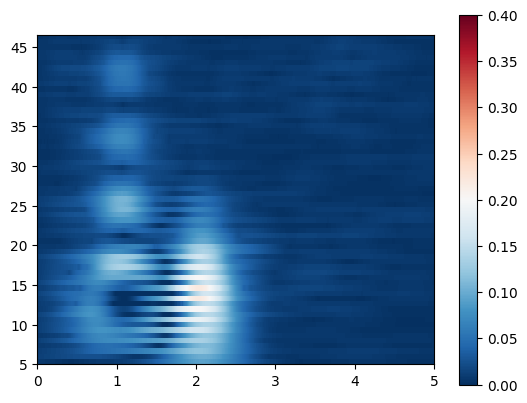

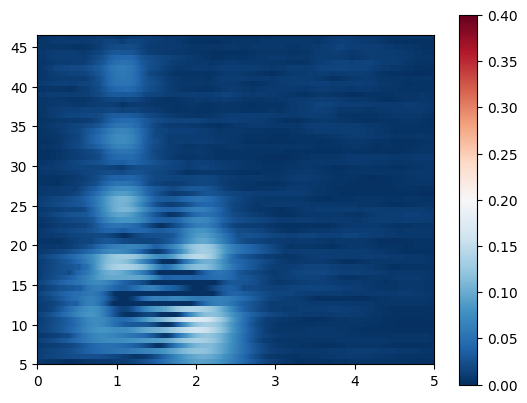

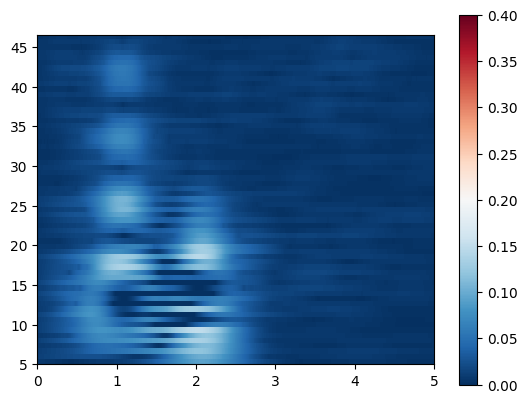

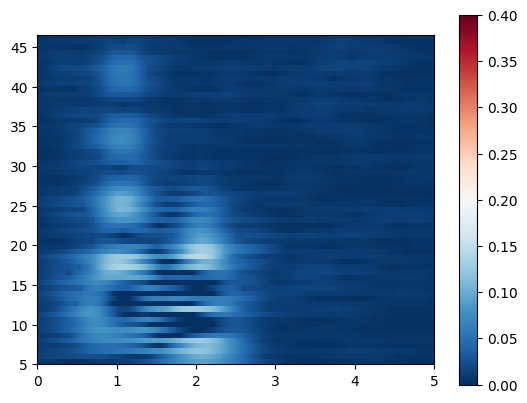

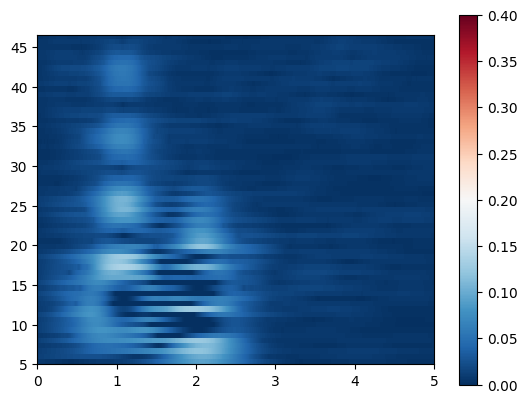

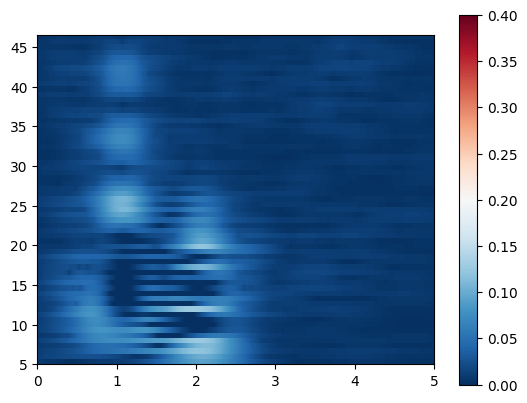

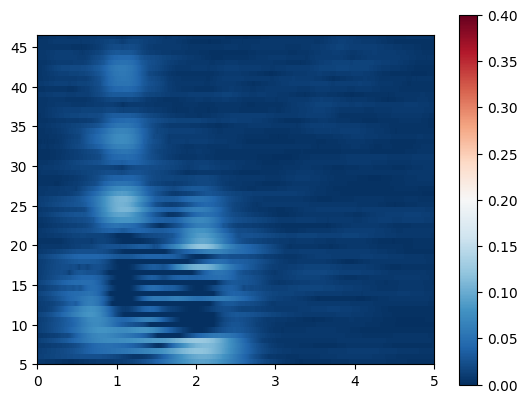

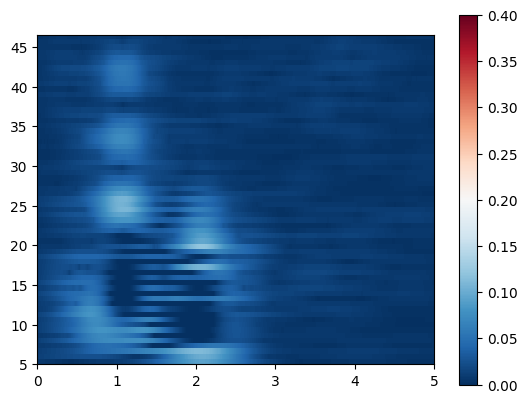

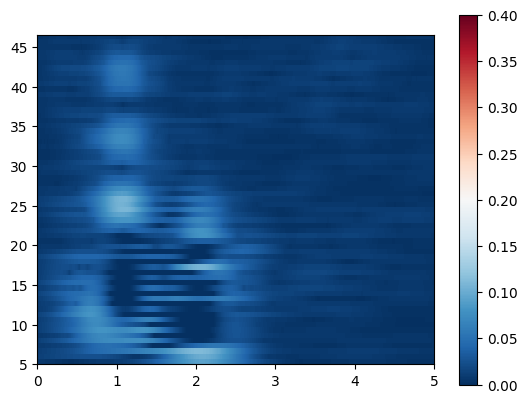

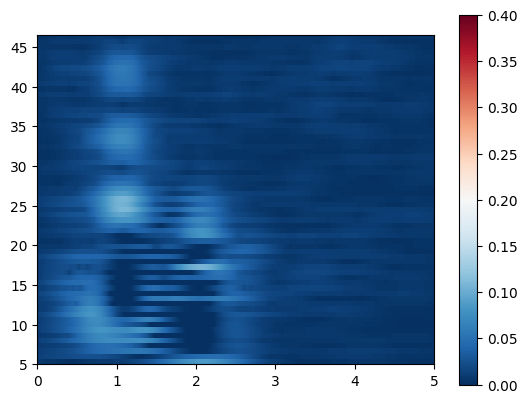

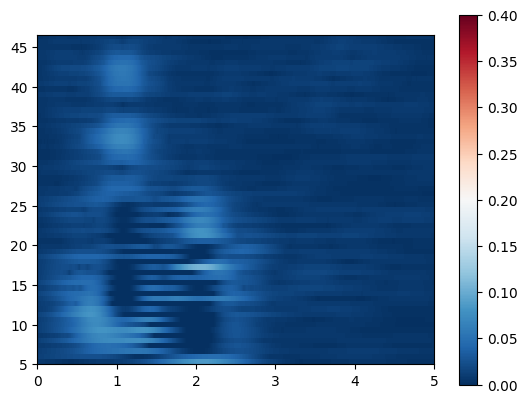

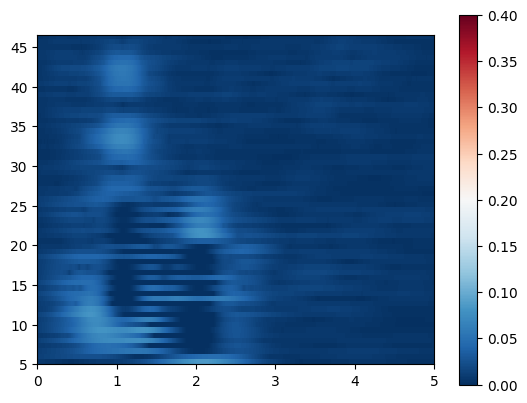

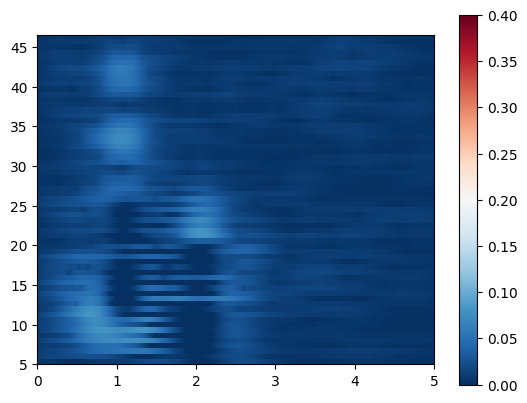

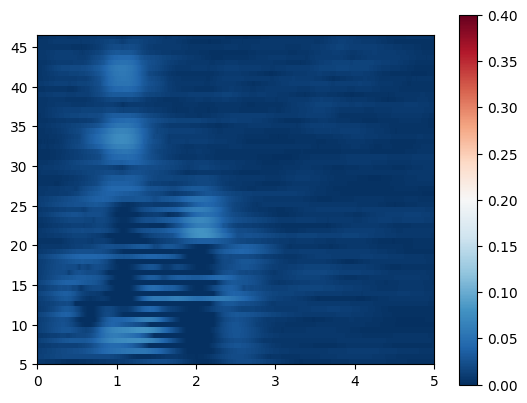

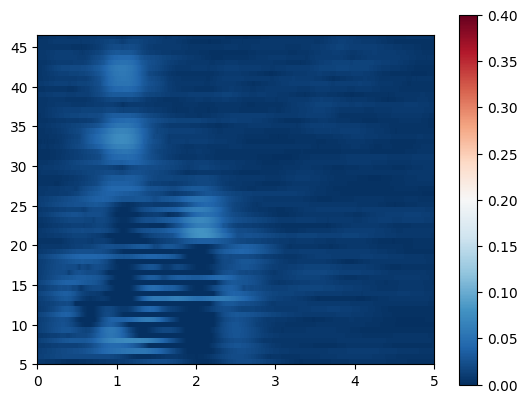

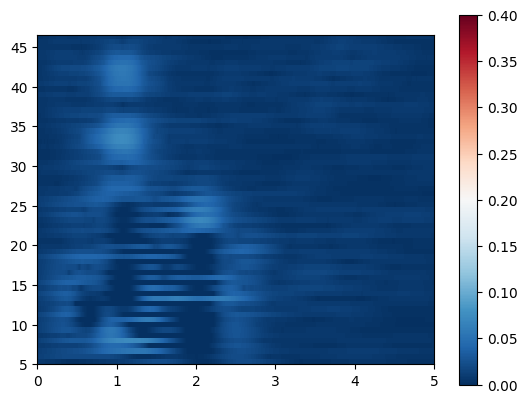

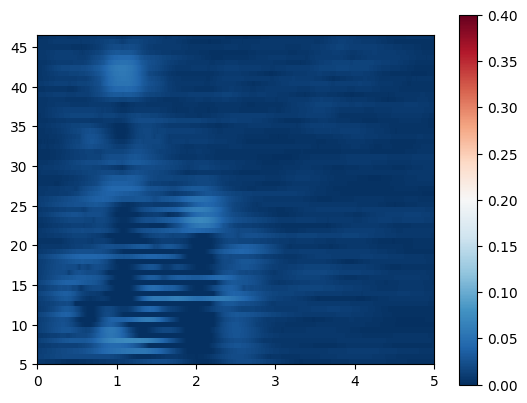

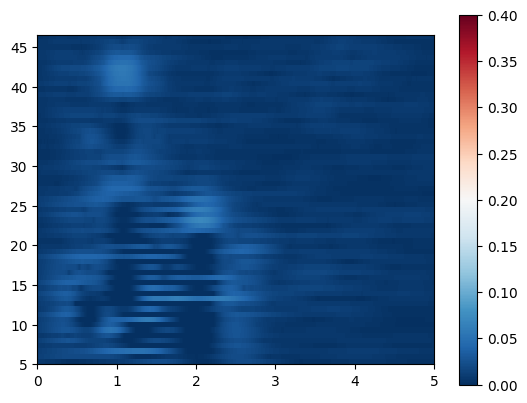

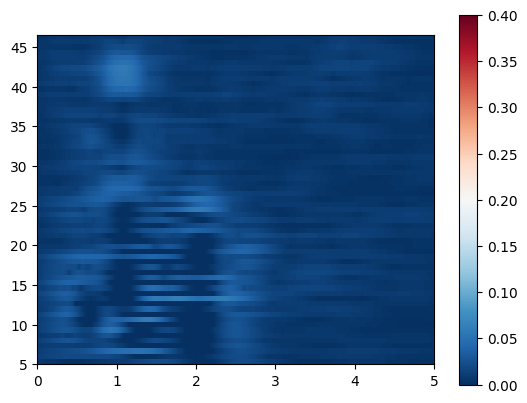

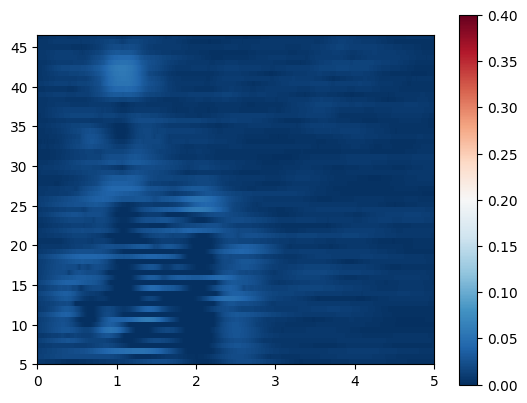

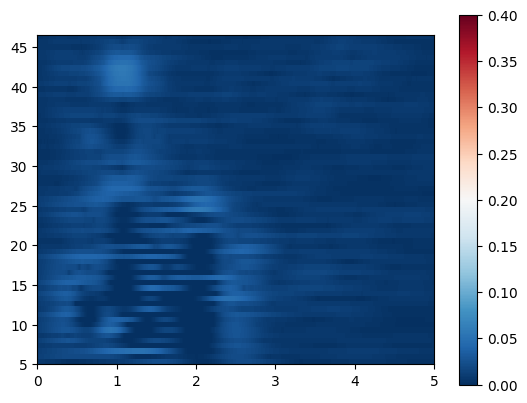

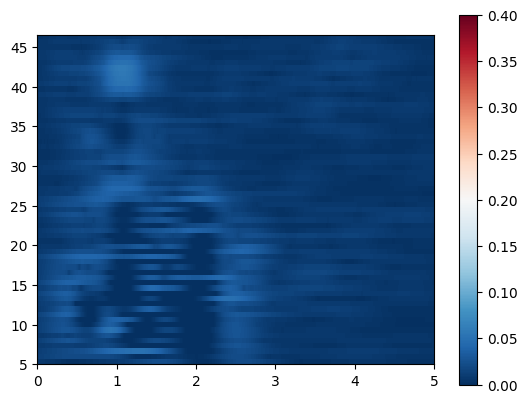

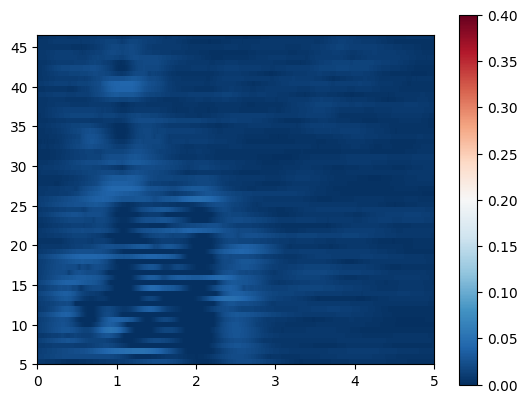

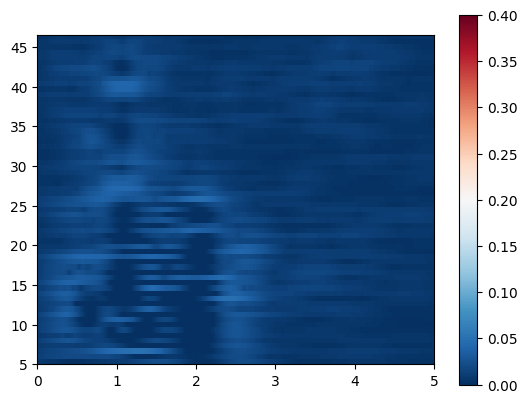

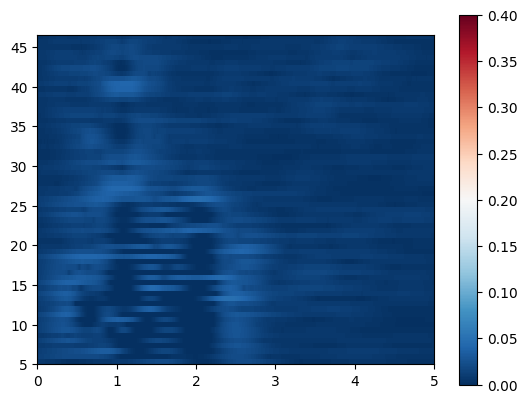

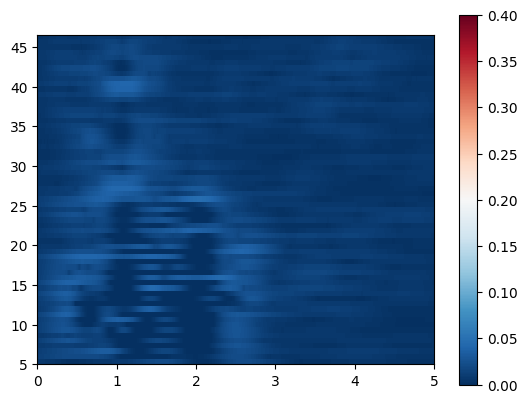

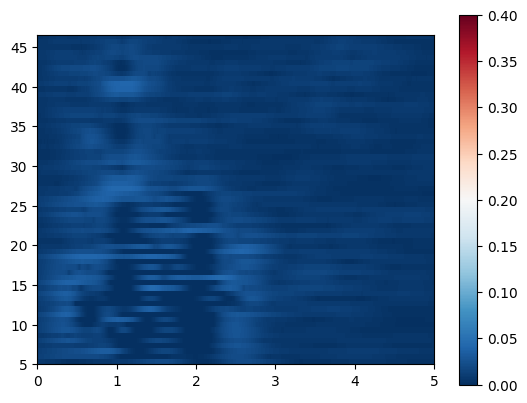

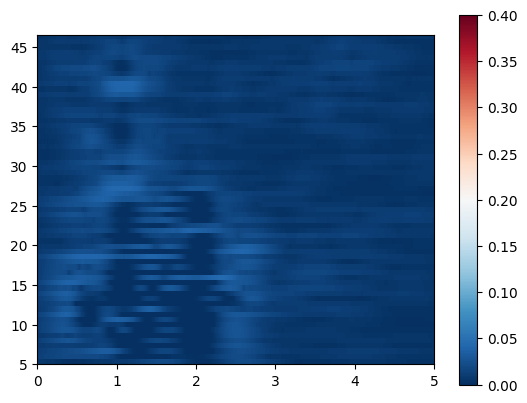

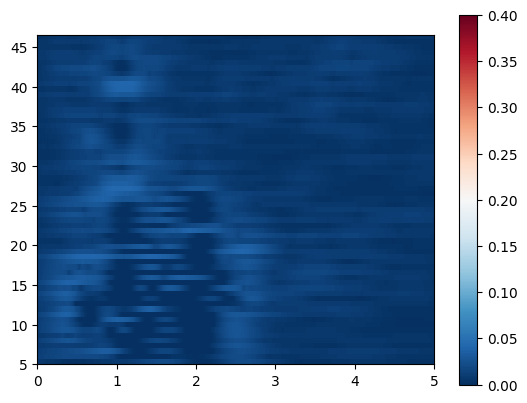

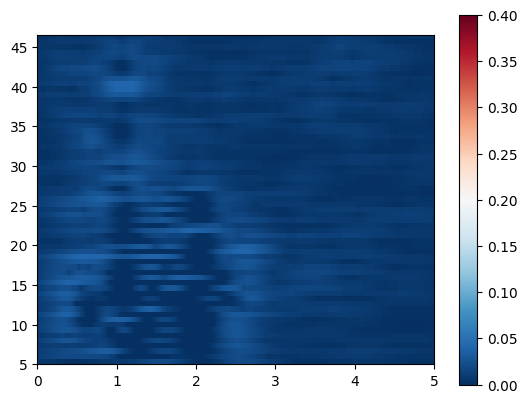

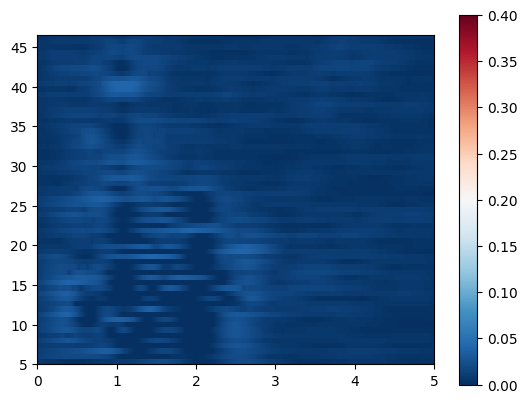

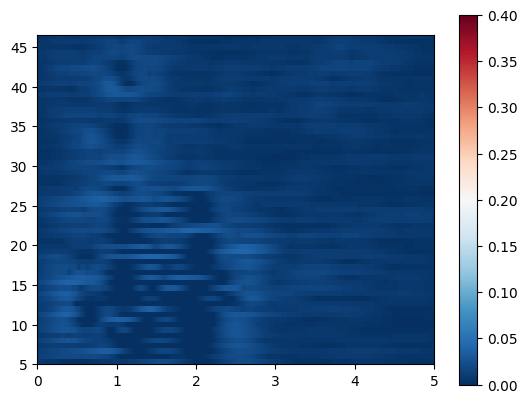

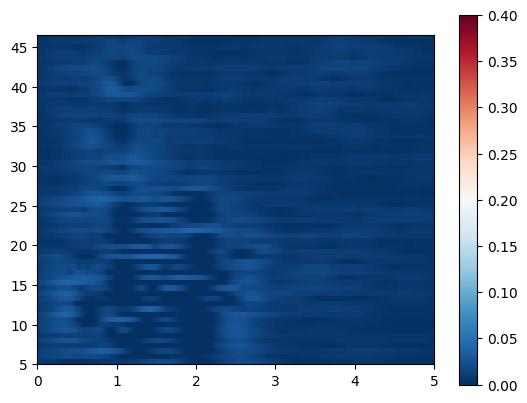

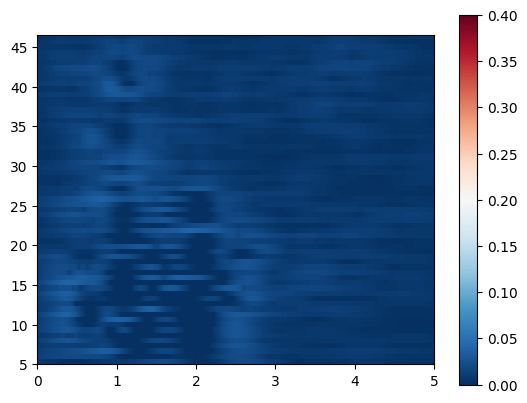

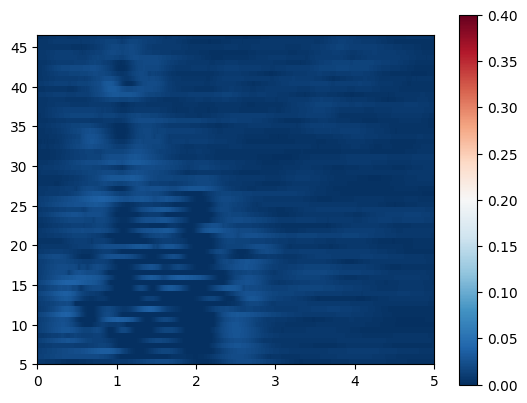

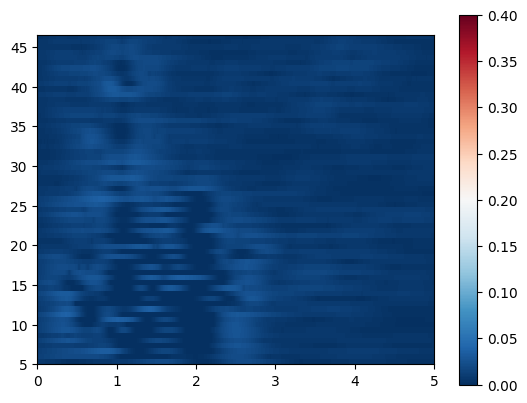

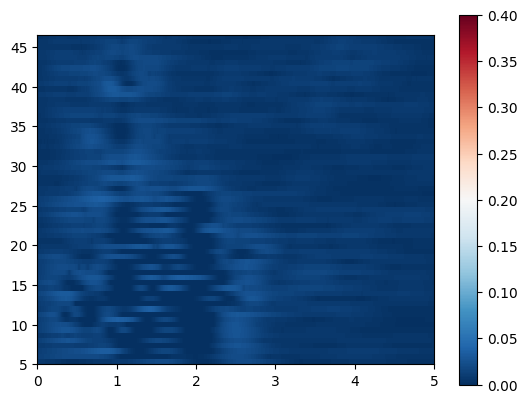

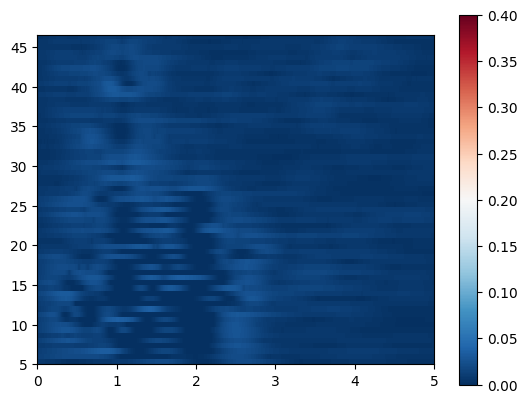

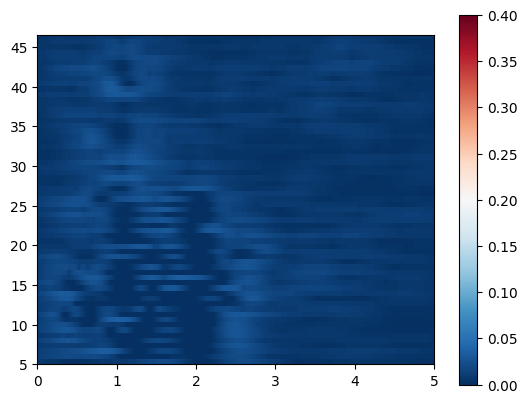

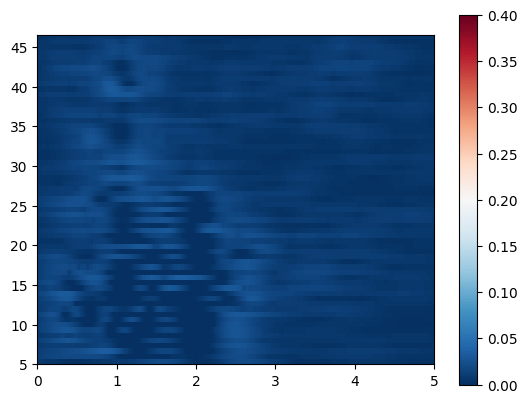

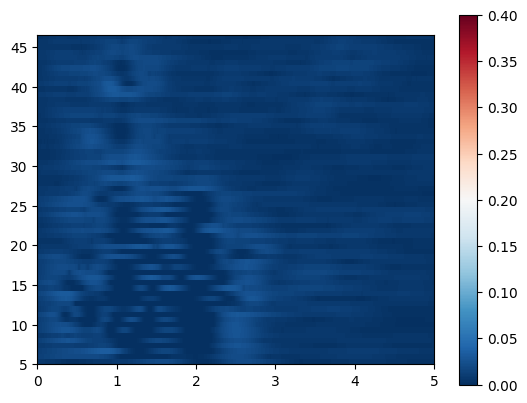

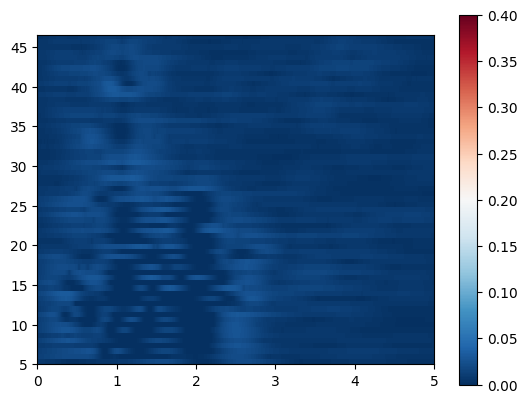

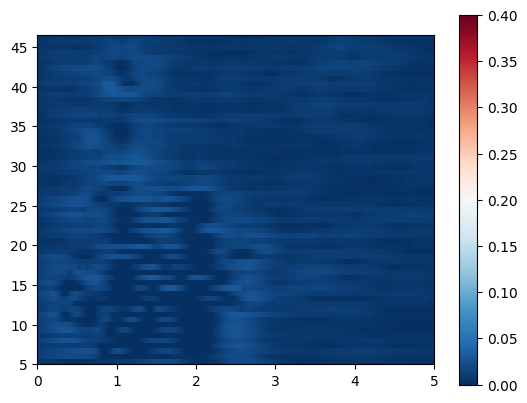

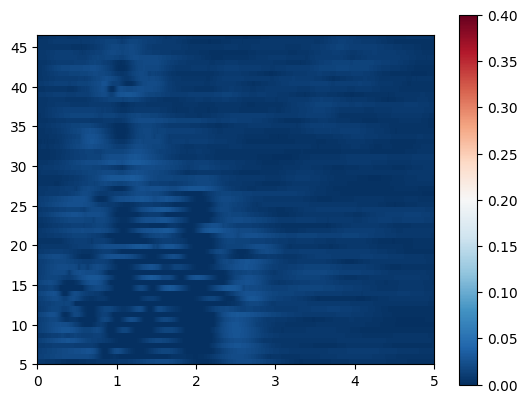

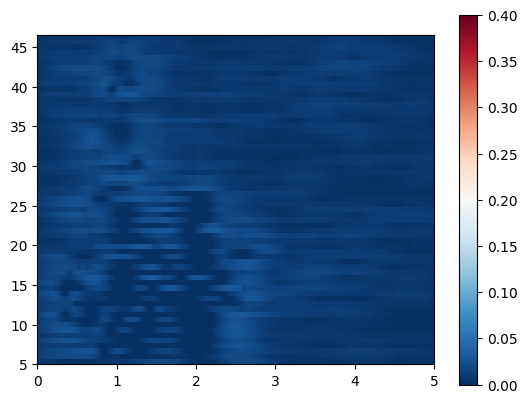

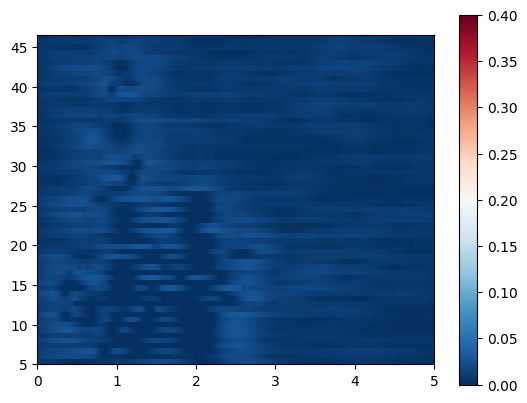

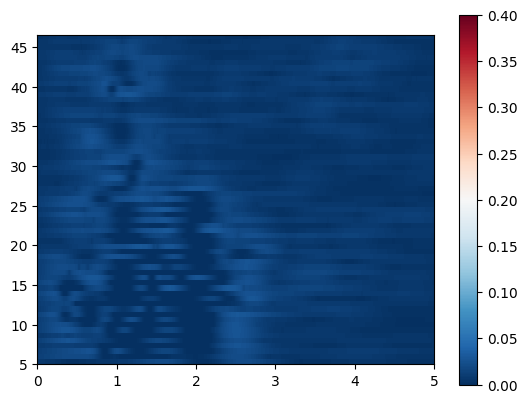

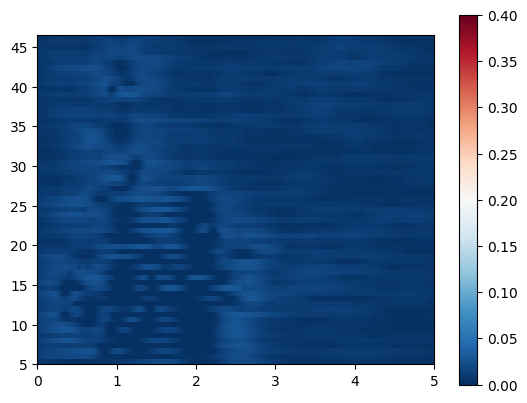

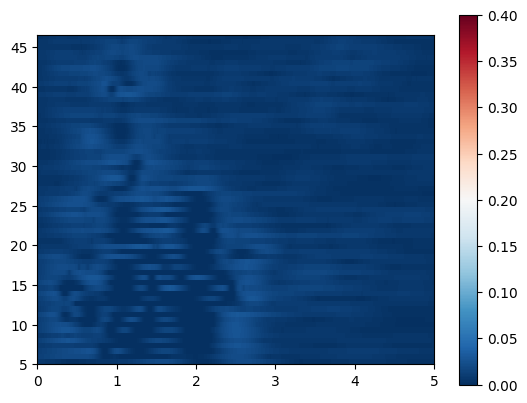

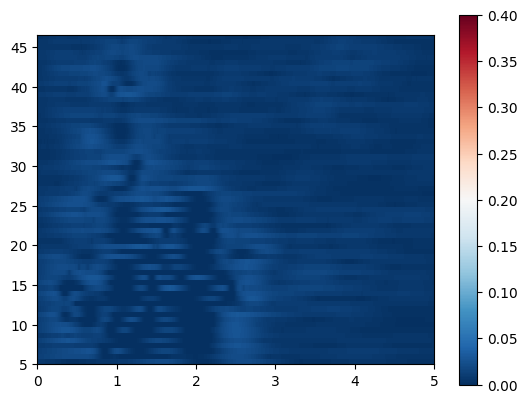

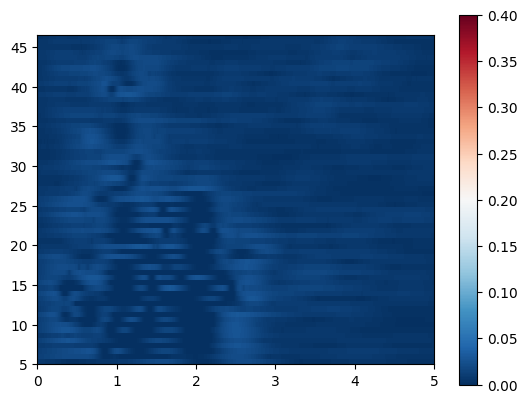

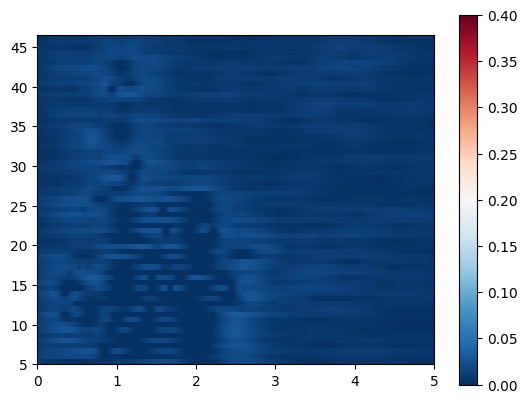

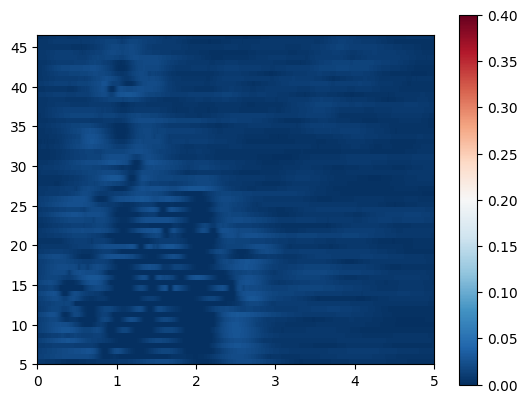

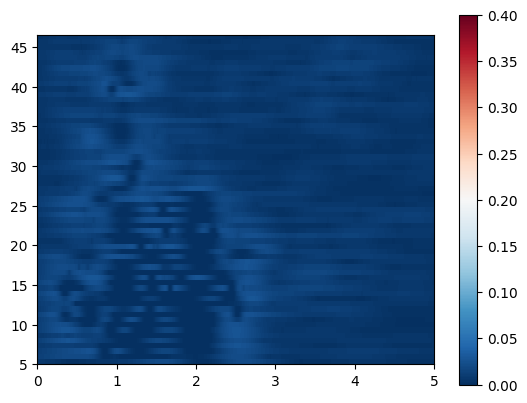

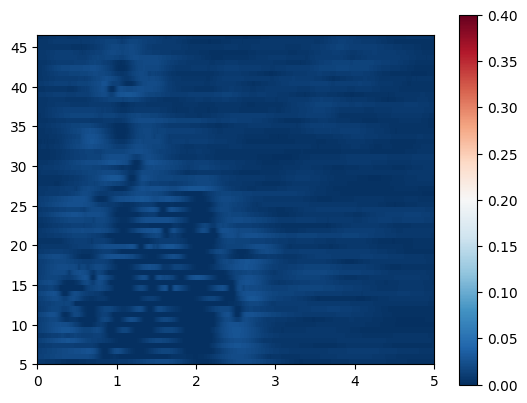

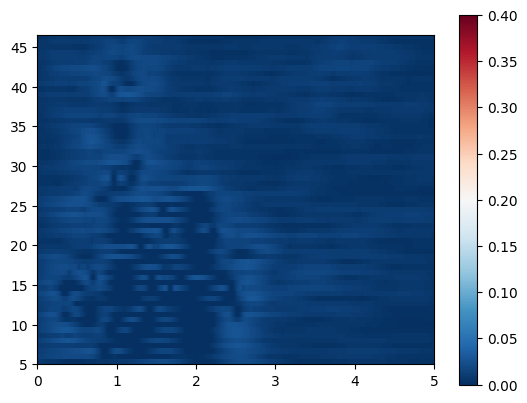

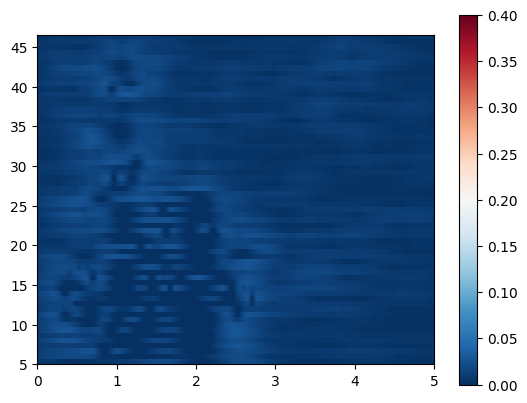

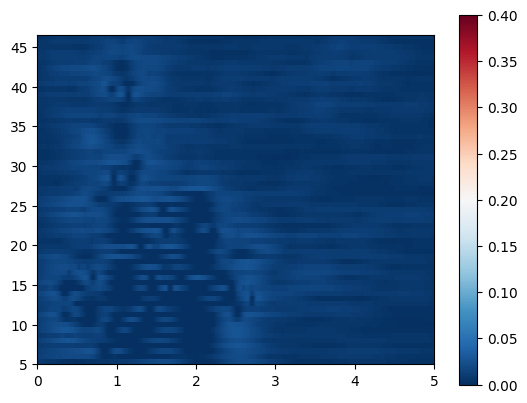

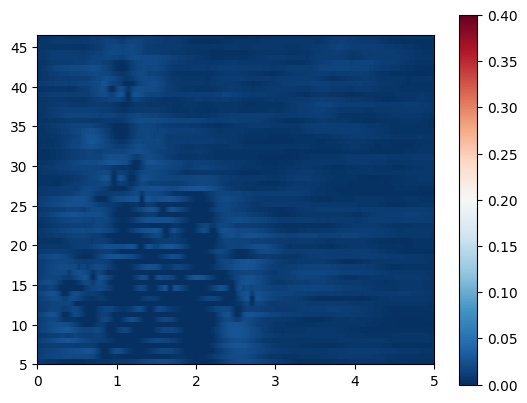

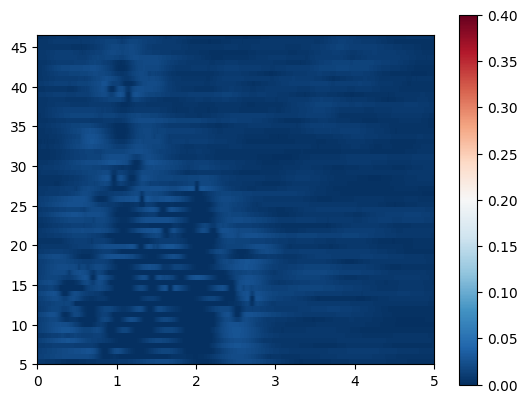

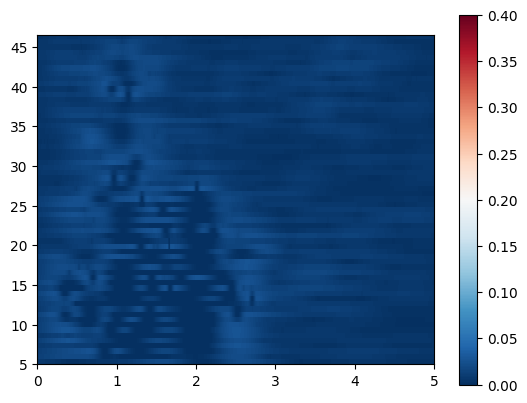

In [ ]:
from mne.filter import filter_data
from scipy.signal import hilbert, argrelextrema
from scipy.stats import linregress

from betaburst.detection._utils import gaus2d, overlap, fwhm_burst_norm

times =  np.linspace(
    0,
    5,
    int((np.abs(5 - 0)) * 250),
)
times = np.around(times, decimals=3)

canon_band = [10, 35]
w_size = 0.26

canon_band_range = np.where(
(freqs >= canon_band[0] - 3) & (freqs <= canon_band[1] + 3)
)[0]
ch_id = 0

null_threshold = np.zeros((freqs[canon_band_range].shape[0], 1))

raw_trials = epochs[:, ch_id, :]
TF = tfs[:, ch_id, canon_band_range]
times=times
search_freqs = freqs[canon_band_range]
band_lims = canon_band
fooof_thresh= null_threshold
sfreq = 250
channel = ch_id
w_size=0.26
remove_fooof=True
verbose=False

bursts = {
        "channel": [],
        "trial": [],
        "waveform": [],
        "peak_freq": [],
        "peak_amp_iter": [],
        "peak_amp_base": [],
        "peak_time": [],
        "peak_adjustment": [],
        "fwhm_freq": [],
        "fwhm_time": [],
        "polarity": [],
        "volume": [],
    }

# Compute ERF/ERP.
erf = np.mean(raw_trials, axis=0)

# Grid for computing 2D Gaussians
x_idx, y_idx = np.meshgrid(range(len(times)), range(len(search_freqs)))

# Window size in points
wlen = int(w_size * sfreq)
half_wlen = int(wlen * 0.5)

# Operate on a trial
t_idx = 8
tr = TF[t_idx]
print('Trial idx:', t_idx)
plt.figure()
plt.imshow(tr,  aspect=1/10, cmap="RdBu_r", interpolation="none", origin="lower", extent=[0, epochs.shape[2]/fs,  freqs[0], freqs[-1]],vmin=0, vmax=0.4)
plt.colorbar()
plt.title('Original TF')

# Regress out ERF
slope, intercept, _, _, _ = linregress(erf, raw_trials[t_idx, :])
raw_trials[t_idx, :] = raw_trials[t_idx, :] - (intercept + slope * erf)

# Optionally, subtract 1/f threshold.
trial_TF = tr

# TF for iterating
trial_TF_iter = np.copy(trial_TF)

prnt_count = 0

while True:
    
    # Compute noise floor.
    std_amp = 4
    thresh = std_amp * np.std(trial_TF_iter)

    # Find peak
    [peak_freq_idx, peak_time_idx] = np.unravel_index(
        np.argmax(trial_TF_iter), trial_TF.shape
    )
    peak_freq = search_freqs[peak_freq_idx]
    peak_amp_iter = trial_TF_iter[peak_freq_idx, peak_time_idx]
    peak_amp_base = trial_TF[peak_freq_idx, peak_time_idx]
    
    # Stop if no peak lies above the trheshold.
    if peak_amp_iter < thresh:
        if t_idx not in np.unique(bursts["trial"]):
            if verbose == True:
                print(
                    "\t\tTrial {} contains no more bursts in the frequency ".format(t_idx)
                    + "range of interest..."
                )
        break

    # Fit 2D Gaussian and subtract from TF.
    # Do not overestimate the fitted gaussain.
    proxy_trial_TF_iter = np.copy(trial_TF_iter)
    proxy_trial_TF_iter = proxy_trial_TF_iter - 2 * np.std(
        proxy_trial_TF_iter
    )
    proxy_trial_TF_iter[proxy_trial_TF_iter < 0] = 0
    right_loc, left_loc, up_loc, down_loc = fwhm_burst_norm(
        proxy_trial_TF_iter, (peak_freq_idx, peak_time_idx)
    )

    # Detect and remove degenerate Gaussian (limits not found).
    vert_isnan = any(np.isnan([up_loc, down_loc]))
    horiz_isnan = any(np.isnan([right_loc, left_loc]))
    if vert_isnan:
        v_sh = int((search_freqs.shape[0] - peak_freq_idx) / 2)
        if v_sh <= 0:
            v_sh = 1
        up_loc = v_sh
        down_loc = v_sh

    elif horiz_isnan:
        h_sh = int((times.shape[0] - peak_time_idx) / 2)
        if h_sh <= 0:
            h_sh = 1
        right_loc = h_sh
        left_loc = h_sh

    hv_isnan = any([vert_isnan, horiz_isnan])
    
    # Compute FWHM and convert to SD.
    fwhm_f_idx = up_loc + down_loc
    fwhm_f = (search_freqs[1] - search_freqs[0]) * fwhm_f_idx
    fwhm_t_idx = left_loc + right_loc
    fwhm_t = (times[1] - times[0]) * fwhm_t_idx
    sigma_t = (fwhm_t_idx) / 2.355
    sigma_f = (fwhm_f_idx) / 2.355
    
    # Fitted Gaussian.
    z = peak_amp_iter * gaus2d(
        x_idx, y_idx, mx=peak_time_idx, my=peak_freq_idx, sx=sigma_t, sy=sigma_f
    )
    new_trial_TF_iter = trial_TF_iter - z
    plt.figure()
    plt.imshow(new_trial_TF_iter,  aspect=1/10, cmap="RdBu_r", interpolation="none", origin="lower", extent=[0, epochs.shape[2]/fs,  freqs[0], freqs[-1]],vmin=0, vmax=0.4)
    plt.colorbar()
    # Proceed only if the fitted Gaussian is not degenerate
    # and within the requested frequency band limits.
    if all(
        [peak_freq >= band_lims[0], peak_freq <= band_lims[1], not hv_isnan]
    ):

        # Bandpass filtering within the burst frequency range.
        freq_range = [
            np.max([0, peak_freq_idx - down_loc]),
            np.min([len(search_freqs) - 1, peak_freq_idx + up_loc])
        ]
        filtered = filter_data(
            raw_trials[t_idx, :].reshape(1, -1),
            sfreq,
            search_freqs[freq_range[0]],
            search_freqs[freq_range[1]],
            verbose=False
        )

        # Hilbert transform
        analytic_signal = hilbert(filtered)

        # Get phase
        instantaneous_phase = np.unwrap(np.angle(analytic_signal)) % np.pi

        # Find phase local minima (near 0)
        min_phase_pts = argrelextrema(instantaneous_phase.T, np.less)[0]

        new_peak_time_idx = peak_time_idx

        # Find local phase minima with negative deflection closest to TF peak.
        # If no minimum is found, the error is caught and no burst is added.
        try:
            new_peak_time_idx = min_phase_pts[np.argmin(np.abs(peak_time_idx - min_phase_pts))]
            adjustment = (new_peak_time_idx - peak_time_idx) * 1 / sfreq
        except:
            if verbose == True:
                if prnt_count == 0:
                    flm = "\t\tTrial {}:\n\t\t\tSkipping a candidate burst, ".format(
                        t_idx
                    )
                else:
                    flm = "\t\t\tSkipping a candidate burst, "
                print(
                    flm
                    + "as no local minima were detected in the instantaneous phase of the signal."
                )
            prnt_count += 1

            adjustment = 1

        # Keep if adjustment less than 30ms.
        if np.abs(adjustment) < 0.03:
            
            # If burst won't be cutoff...
            if (
                new_peak_time_idx >= half_wlen
                and new_peak_time_idx + half_wlen <= len(times)
            ):
                peak_time = times[new_peak_time_idx]

                overlapped = False

                # Check for overlap.
                for b_idx in range(len(bursts['peak_time'])):
                    
                    o_t = bursts["peak_time"][b_idx]
                    o_fwhm_t = bursts["fwhm_time"][b_idx]
                    
                    if overlap(
                        [peak_time - 0.5 * fwhm_t, peak_time + 0.5 * fwhm_t],
                        [o_t - 0.5 * o_fwhm_t, o_t + 0.5 * o_fwhm_t],
                    ):
                        overlapped = True
                        break

                if not overlapped:
                    
                    # Get burst.
                    burst = raw_trials[
                        t_idx,
                        new_peak_time_idx
                        - half_wlen : new_peak_time_idx
                        + half_wlen,
                    ]

                    # Remove DC offset.
                    burst = burst - np.mean(burst)
                    burst_times = (
                        times[
                            new_peak_time_idx
                            - half_wlen : new_peak_time_idx
                            + half_wlen
                        ]
                        - times[new_peak_time_idx]
                    )

                    # Flip if positive deflection.
                    peak_dists = np.abs(
                        argrelextrema(filtered.T, np.greater)[0] - new_peak_time_idx
                    )
                    trough_dists = np.abs(
                        argrelextrema(filtered.T, np.less)[0] - new_peak_time_idx
                    )

                    polarity = 0
                    if len(trough_dists) == 0 or (
                        len(peak_dists) > 0
                        and np.min(peak_dists) < np.min(trough_dists)
                    ):
                        burst *= -1.0
                        polarity = 1

                    bursts["trial"].append(int(t_idx))
                    bursts["channel"].append(channel)
                    bursts["waveform"].append(burst)
                    bursts["peak_freq"].append(peak_freq)
                    bursts["peak_amp_iter"].append(peak_amp_iter)
                    bursts["peak_amp_base"].append(peak_amp_base)
                    bursts["peak_time"].append(peak_time)
                    bursts["peak_adjustment"].append(adjustment)
                    bursts["fwhm_freq"].append(fwhm_f)
                    bursts["fwhm_time"].append(fwhm_t)
                    bursts["polarity"].append(polarity)
                    bursts["volume"].append(np.sum(z))

    trial_TF_iter = new_trial_TF_iter

bursts["channel"] = np.array(bursts["channel"])
bursts["trial"] = np.array(bursts["trial"])
bursts["waveform"] = np.array(bursts["waveform"])
try:
    bursts["waveform_times"] = burst_times
except:
    bursts["waveform_times"] = []
bursts["peak_freq"] = np.array(bursts["peak_freq"])
bursts["peak_amp_iter"] = np.array(bursts["peak_amp_iter"])
bursts["peak_amp_base"] = np.array(bursts["peak_amp_base"])
bursts["peak_time"] = np.array(bursts["peak_time"])
bursts["peak_adjustment"] = np.array(bursts["peak_adjustment"])
bursts["fwhm_freq"] = np.array(bursts["fwhm_freq"])
bursts["fwhm_time"] = np.array(bursts["fwhm_time"])
bursts["polarity"] = np.array(bursts["polarity"])
bursts["volume"] = np.array(bursts["volume"])

